# To start

记录
1. Gurobi 在colab上只能用WLS License, 有效期一个月, 可在学校区域网下续
https://license.gurobi.com/manager/licenses/?id=2611849

In [ ]:
!pip install gurobipy igraph

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['GRB_LICENSE_FILE'] = '/content/drive/MyDrive/gurobi.lic'
os.chdir("/content/drive/My Drive/Colab Notebooks/Causality/Causal Discovery Toolbox-CDT/Exact learning methods/Pavel-GitLab-ori/")

!export PYTHONPATH="$PYTHONPATH:/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks-data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from typing import Tuple, Dict
import gurobipy as gp
import numpy as np
from gurobipy import GRB
from gurobipy import Model
from omegaconf import DictConfig, OmegaConf
import notears.utils as utils
import igraph as ig
from dagsolvers.dagsolver_utils import apply_threshold, find_optimal_threshold_for_shd, find_minimal_dag_threshold


def find_cycles(edges, mode):
    vertices = set(e[0] for e in edges)
    vertices.update(e[1] for e in edges)

    visited = set()
    on_stack = set()
    parent = {}
    stack = []
    shortest_cycle = None
    found_cycles = []
    number_of_cycles = 0

    for root in vertices:
        if root in visited:
            continue
        stack.append(root)
        while stack:
            v = stack[-1]
            if v not in visited:
                visited.add(v)
                on_stack.add(v)
            else:
                if v in on_stack:
                    on_stack.remove(v)
                # else:
                #     print('DEBUG')
                stack.pop()

            neighbors = [e[1] for e in edges if e[0] == v]
            for neighbor in neighbors:
                if neighbor not in visited:
                    stack.append(neighbor)
                    parent[neighbor] = v
                elif neighbor in on_stack:
                    number_of_cycles += 1
                    # Found a cycle
                    cycle = [neighbor, v] # Back edge
                    p = parent[v]
                    while p != neighbor:
                        cycle.append(p)
                        p=parent[p]
                    #print(cycle)
                    if mode == 'first_cycle':
                        return [cycle] # return the first found cycle
                    found_cycles.append(cycle)
                    if shortest_cycle is None or len(shortest_cycle) > len(cycle):
                        shortest_cycle = cycle

    #print(f'number of cycles: {number_of_cycles}')
    if mode == 'shortest_cycle':
        if shortest_cycle is not None:
            return [shortest_cycle]
        else:
            return []
    elif mode == 'all_cycles':
        return found_cycles
    elif mode == 'first_cycle':
        return []
    else:
        assert False, f'Invalid mode{mode}'


def extract_adj_matrix(edges_vals, weights_vals, d):
    W = np.zeros((d,d))
    for v1 in range(d):
        for v2 in range(d):
            if v1 != v2:
                if edges_vals[v1, v2] > 0.5:
                    W[v1, v2] = weights_vals[(v1, v2)]
    return W

def extract_adj_matrix_no_vars(weights_vals, d):
    A = np.zeros((d,d))
    for v1 in range(d):
        for v2 in range(d):
            A[v1, v2] = weights_vals[(v1, v2)]
    return A

def check_for_cycles(model, where):
    if where == GRB.Callback.MESSAGE:
        pass
        # edges_vals = model.cbGetSolution(model._edges_vars)
        # weights_vals = model.cbGetSolution(model._edges_weights)
        # W = extract_adj_matrix(edges_vals, weights_vals)
        # print(W)

    if where == GRB.Callback.MIPSOL:
        #print('CALLBACK')
        # make a list of edges selected in the solution
        constr_added = False
        vals = model.cbGetSolution(model._edges_vars)
        weights_vals = model.cbGetSolution(model._edges_weights)
        selected_edges = gp.tuplelist((i, j) for i, j in model._edges_vars.keys()
                                      if vals[i, j] > 0.5)
        # find the shortest cycle in the selected edge list
        cycles = find_cycles(selected_edges, model._callback_mode)
        for cycle in cycles:
            edges_of_cycle = []
            for i in range(len(cycle)-1):
                edges_of_cycle.append((cycle[i+1], cycle[i]))
            edges_of_cycle.append((cycle[0], cycle[-1]))
            #callback_constraints[1] = callback_constraints[1] + 1
            #print('NEW CONSTRAINT')
            model._lazy_count += 1
            model.cbLazy(gp.quicksum(model._edges_vars[i, j] for i, j in edges_of_cycle)
                         <= len(edges_of_cycle)-1)
            constr_added = True

        # Compute solving statistics
        rt = model.cbGet(GRB.Callback.RUNTIME)
        if not constr_added and model._B_ref is not None and (rt - model._last_time_stats > 60): # Compute statistics every 60 seconds
            B_true = model._B_ref
            assert isinstance(B_true, np.ndarray)
            assert set(np.unique(B_true)).issubset({0, 1})
            model._last_time_stats = rt
            W_sol = extract_adj_matrix(vals, weights_vals, model._d)
            dag_t, W_sol = find_minimal_dag_threshold(W_sol)
            #W_sol = apply_threshold(W_sol, 0.3)
            default_threshold = 0.3
            W_t = apply_threshold(W_sol, default_threshold)
            shd = utils.count_accuracy(B_true, W_t != 0)['shd']
            objval = model.cbGet(GRB.Callback.MIPSOL_OBJ)

            best_t, best_shd = find_optimal_threshold_for_shd(B_true, W_sol, [], [], np.zeros_like(B_true), np.zeros_like(B_true))

            print(f't{default_threshold}_SHD: {shd} BEST_SHD: {best_shd} BEST_t: {best_t} OBJ: {objval} DAG_t: {dag_t}')
            model._stats.append((round(rt), shd, best_shd, best_t, objval, dag_t))


def construct_matrix_vars(m: Model, d: int, matrix_name: str, constraints_mode, weights_bound, tabu_edges, diagonal=False) -> Tuple[Dict, Dict]:
    edges_vars = {}
    edges_weights = {}
    for v1 in range(d):
        for v2 in range(d):
            if diagonal or v1 != v2:
                if constraints_mode != 'no-vars':
                    edges_vars[v1,v2] = m.addVar(vtype=GRB.BINARY, name=f'{matrix_name}_{v1}->{v2}')
                edges_weights[v1,v2] = m.addVar(lb = float('-inf'),vtype=GRB.CONTINUOUS, name=f'{matrix_name}_weight{v1}->{v2}')

                if constraints_mode == 'no-weights':
                    m.addConstr(edges_weights[v1,v2] == edges_vars[v1,v2])
                elif constraints_mode == 'no-vars':
                    m.addConstr(edges_weights[v1,v2] <= weights_bound)
                    m.addConstr(-edges_weights[v1,v2] <= weights_bound)
                else:
                    m.addConstr(edges_weights[v1,v2] <= weights_bound * edges_vars[v1,v2])
                    m.addConstr(-edges_weights[v1,v2] <= weights_bound * edges_vars[v1,v2])
    if tabu_edges is not None:
        for (v1,v2) in tabu_edges:
            m.addConstr(edges_vars[v1,v2] == 0)
            m.addConstr(edges_weights[v1,v2] == 0)
    return edges_vars, edges_weights

def dag_adj_binary(weight_matrix, threshold=0):
    # Load MAG adjacency matrix
    mag = np.array(weight_matrix)  # <-- 使用你给的矩阵（略）

    # Step 1: 构造初始有向图
    G = nx.DiGraph()
    num_nodes = mag.shape[0]
    G.add_nodes_from(range(num_nodes))

    # 添加所有非零边
    for i in range(num_nodes):
        for j in range(num_nodes):
            weight = mag[i, j]
            if weight != 0:
                G.add_edge(i, j, weight=weight)

    # Step 2: 检测环并去掉形成环的“弱边”
    def make_acyclic(graph):
        acyclic_graph = graph.copy()
        while True:
            try:
                cycle = nx.find_cycle(acyclic_graph, orientation='original')
                # 找到环中绝对权重最小的边
                weakest_edge = min(cycle, key=lambda e: abs(acyclic_graph[e[0]][e[1]]['weight']))
                acyclic_graph.remove_edge(weakest_edge[0], weakest_edge[1])
            except nx.NetworkXNoCycle:
                break
        return acyclic_graph

    dag = make_acyclic(G)
    dag_adj_binary = nx.to_numpy_array(dag, weight=None).astype(int)

    return dag_adj_binary

def solve_milp(X, cfg: DictConfig, w_threshold, max_in_degree, max_out_degree, Y=None, B_ref=None, tabu_edges=None):

    time_limit = cfg.time_limit
    lambda1 = cfg.lambda1
    lambda2 = cfg.lambda2
    loss_type = cfg.loss_type
    constraints_mode = cfg.constraints_mode
    mode = cfg.callback_mode
    robust = cfg.robust
    weights_bound = cfg.weights_bound
    reg_type = cfg.reg_type
    a_reg_type = cfg.a_reg_type
    target_mip_gap = cfg.target_mip_gap

    n, d = X.shape
    if Y is None:
        Y = []
    p = len(Y) # The number of historical data slices
     # 'no-weights'
    # if loss_type == 'l2':
    #     X = X - np.mean(X, axis=0, keepdims=True)


    m = gp.Model()
    W_edges_vars, W_edges_weights = construct_matrix_vars(m, d, 'W', constraints_mode, weights_bound, tabu_edges)
    for v1 in range(d):
        for v2 in range(v1):
            m.addConstr(W_edges_vars[v2,v1] + W_edges_vars[v1,v2] <= 1)

    for v in range(d):
        m.addConstr(gp.quicksum(W_edges_vars[v, j] for j in range(d) if j != v) <= max_out_degree)
        m.addConstr(gp.quicksum(W_edges_vars[i, v] for i in range(d) if i != v) <= max_in_degree)

    A_edges_vars = []
    A_edges_weights = []

    a_constraints_mode = '' if a_reg_type == 'l1' else 'no-vars'

    for t in range(p):
        A_t_edges_vars, A_t_edges_weights = construct_matrix_vars(m, d, f'A_{t}', a_constraints_mode, weights_bound, diagonal=True, tabu_edges=None)
        A_edges_vars.append(A_t_edges_vars)
        A_edges_weights.append(A_t_edges_weights)

    robust_vars = {}
    quad_diff = {}
    if robust:
        for i in range(n):
            robust_vars[i] = m.addVar(vtype=GRB.BINARY, name=f's{i}')
            for j in range(d):
                quad_diff[i, j] = m.addVar(lb = float('-inf'),vtype=GRB.CONTINUOUS, name=f'q{i}-{j}')
        r = round(0.9 * n)
        m.addConstr(gp.quicksum(robust_vars[i] for i in range(n)) >= r)
        for i in range(n):
            for j in range(d):
                m.addConstr((X[i,j] - gp.quicksum(X[i, k] * W_edges_weights[k, j] for k in range(d) if k != j) - gp.quicksum(Y[t][i, k] * A_edges_weights[t][k, j] for k in range(d) for t in range(p)))**2 == quad_diff[i,j])
        robust_objective = gp.quicksum(quad_diff[i,j] * robust_vars[i] for i in range(n) for j in range(d))
    #callback_constraints = {}
    #callback_constraints[1] = 0


    # regulazition
    if reg_type == 'l2':
        reg = gp.quicksum(w**2 for w in W_edges_weights.values())
        # reg2 = 0
        # for A_t_edges_weights in A_edges_weights:
        #     reg2 = reg2 + gp.quicksum(a**2 for a in A_t_edges_weights.values())
    elif reg_type == 'l1':
        reg = gp.quicksum(w for w in W_edges_vars.values())
        # reg2 = 0
        # l2 reg for As becouse we dont have decision variables for them.
        # for A_t_edges_weights in A_edges_weights:
        #     reg2 = reg2 + gp.quicksum(a**2 for a in A_t_edges_weights.values())
        # for A_t_edges_vars in A_edges_vars:
        #     reg = reg + gp.quicksum(a for a in A_t_edges_vars.values())
    else:
        assert False

    if a_reg_type == 'l2':
        reg2 = 0
        for A_t_edges_weights in A_edges_weights:
            reg2 = reg2 + gp.quicksum(a**2 for a in A_t_edges_weights.values())
    elif a_reg_type == 'l1':
        reg2 = 0
        for A_t_edges_vars in A_edges_vars:
            reg = reg + gp.quicksum(a for a in A_t_edges_vars.values())
    else:
        assert False


    # Cost function
    if loss_type == 'l2':
        if robust:
            m.setObjective(robust_objective + lambda1 * reg / d + lambda2 * reg2 / d, GRB.MINIMIZE)
        else:
            m.setObjective(gp.quicksum((X[i,j] - gp.quicksum(X[i, k] * W_edges_weights[k, j] for k in range(d) if k != j)
                                        - gp.quicksum(Y[t][i, k] * A_edges_weights[t][k, j] for k in range(d) for t in range(p))
                                        )**2 for i in range(n) for j in range(d))/n + lambda1 * reg / d + lambda2 * reg2 / d, GRB.MINIMIZE)
            print(m.getObjective().getValue())
    elif loss_type == 'l1':

        abs_vars = {}
        for i in range(n):
            for j in range(d):
                abs_vars[i,j] = m.addVar(vtype=GRB.CONTINUOUS, name=f'abs{i}-{j})')
                m.addConstr((X[i,j] - gp.quicksum(X[i, k] * W_edges_weights[k, j] for k in range(d) if k != j) - gp.quicksum(Y[t][i, k] * A_edges_weights[t][k, j] for k in range(d) for t in range(p))) <= abs_vars[i,j])
                m.addConstr(-(X[i,j] - gp.quicksum(X[i, k] * W_edges_weights[k, j] for k in range(d) if k != j) - gp.quicksum(Y[t][i, k] * A_edges_weights[t][k, j] for k in range(d) for t in range(p))) <= abs_vars[i,j])

        # abs_edges_weights={}
        # for v1 in range(d):
        #     for v2 in range(d):
        #         if v1 != v2:
        #             abs_edges_weights[v1,v2] = m.addVar(vtype=GRB.CONTINUOUS, name=f'abs_weight{v1}->{v2}')
        #             m.addConstr(W_edges_weights[v1,v2] <= abs_edges_weights[v1,v2])
        #             m.addConstr(-W_edges_weights[v1,v2] <= abs_edges_weights[v1,v2])


        m.setObjective(gp.quicksum(abs_vars[i,j] for i in range(n) for j in range(d))/n + lambda1 * reg / d + lambda2 * reg2 / d, GRB.MINIMIZE)

    m.Params.lazyConstraints = 1
    m.Params.MIPGap = target_mip_gap
    m.params.TimeLimit = time_limit
    m._edges_vars = W_edges_vars
    m._edges_weights = W_edges_weights
    m._lazy_count = 0
    m._last_time_stats = 0
    m._B_ref = B_ref
    m._stats = []
    m._d = d
    m._callback_mode = mode
    m.optimize(check_for_cycles)

    sol_count = m.getAttr(GRB.attr.SolCount)
    if sol_count == 0:
        return None, None, None, None, None
    gap = m.MIPGap
    lazy_count = m._lazy_count
    stats = m._stats

    #print(f'add constraints: {callback_constraints[1]}')

    W_edges_vals = m.getAttr('x', W_edges_vars)
    W_weights_vals = m.getAttr('x', W_edges_weights)

    W = extract_adj_matrix(W_edges_vals, W_weights_vals, d)

    A = []
    for t in range(p):
        #A_t_edges_vals = m.getAttr('x', A_edges_vars[t])
        A_t_weights_vals = m.getAttr('x', A_edges_weights[t])
        A_t = extract_adj_matrix_no_vars(A_t_weights_vals, d)
        A.append(A_t)

    assert utils.is_dag(W)
    m.dispose()
    gp.disposeDefaultEnv()

    # threshold_func = np.vectorize(lambda x: (x if abs(x) > threshold else 0.0))
    # W_t = threshold_func(W)

    W[np.abs(W) < w_threshold] = 0

    return W, A, gap, lazy_count, stats






# Test

## Run ER/SF

### Test

In [ ]:
import numpy as np
import pandas as pd
import time
import os
import networkx as nx
import MetricsDAG
from omegaconf import OmegaConf
import igraph as ig

sem_type = 'dynamic_er_gauss'

# 创建结果文件夹
os.makedirs("results_sythetic_tables", exist_ok=True)
deg_file = "results_sythetic_tables/max_degree.csv"
if not os.path.exists(deg_file):
    pd.DataFrame(columns=["sample", "features_num", "max_in_degree", "max_out_degree"]).to_csv(deg_file, index=False)

# 配置 MILP
cfg = OmegaConf.create({})
cfg.time_limit = 36000
cfg.constraints_mode = 'weights'
cfg.callback_mode = 'all_cycles'
cfg.lambda1 = 1
cfg.lambda2 = 1
cfg.loss_type = 'l2'
cfg.reg_type = 'l1'
cfg.a_reg_type = 'l1'
cfg.robust = False
cfg.weights_bound = 100
cfg.target_mip_gap = 0.001
cfg.tabu_edges = False
cfg.plot_dpi = 100

features_list = list(range(20, 260, 10))
max_degree_list = list(range(5, 500, 10))

# 主循环
for sample in sample_list:
    for features in features_list:
        print(f"\n=== Testing sample={sample}, features={features} ===")
        file_path = f"/content/drive/My Drive/Colab Notebooks/Datasets/Synthetic datasets/{sem_type}/"
        file_name = f'{sem_type}_{features}.npz'
        rawdata = np.load(file_path+file_name, allow_pickle=True)
        df = rawdata['x']
        A = rawdata['y']
        df_sub = df
        X = df_sub
        true_dag = (np.abs(A) > 0).astype(int)

        # Convert A to a binary adjacency matrix (0 or 1) for igraph
        # Any non-zero value in A is considered an edge (1), otherwise no edge (0)
        # true_dag = ig.Graph.Adjacency((A != 0).astype(int).tolist())
        print(f'True DAG: {true_dag}')
        '''
        def weight_to_adjacency(W, tol=1e-8):
            return (np.abs(W) > tol).astype(int)

        A_bin = weight_to_adjacency(W_est)

        G = ig.Graph.Adjacency(
            A_bin.tolist(),
            mode=ig.ADJ_DIRECTED,
            loops=False
        )'''
        W_true = np.zeros((features, features))
        #B_true = np.zeros((features, features), dtype=np.float64)
        #B_true = ( A!= 0).astype(int)   # adjacency matrix
        #print("B_true type:", type(B_true))
        B_true = np.zeros((features, features))

        max_in_degree_test = 0
        max_out_degree_test = 0

        # === 每个 features 的 runtime 表立即生成文件 === #
        runtime_file = f"results_sythetic_tables/runtime_sample{sample}_feat{features}.csv"
        pd.DataFrame(columns=['sample', 'features', 'degree', 'runtime_seconds', 'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore']).to_csv(runtime_file, index=False)

        for max_degree in max_degree_list:
            try:
                print(f"Trying max_degree={max_degree}")
                start_time = time.time()

                W_est, A_est, gap, lazy_count, stats = solve_milp(
                    X, cfg, 0, max_degree, max_degree, Y=[], B_ref=B_true
                )

                elapsed = time.time() - start_time

                if W_est is None:
                    print(f"Not feasible for degree={max_degree}")
                    break

                # 保存边矩阵，文件名包含 sample, features, max_degree
                causal_matrix = dag_adj_binary(W_est)
                print(causal_matrix)
                np.save(f"exdbn_edges_sample{sample}_feat{features}_deg{max_degree}.npy", causal_matrix)

                # 保存 metrics
                met = MetricsDAG.MetricsDAG(causal_matrix, true_dag)
                dict1 = {"sample": sample, "features": features, "degree": max_degree, "runtime_seconds": elapsed}
                dict2 = met.metrics
                pd.DataFrame([{**dict1, **dict2}]).to_csv(runtime_file, mode="a", header=False, index=False)

                print(f"Feasible for max_degree={max_degree}")
                max_in_degree_test = max_degree
                max_out_degree_test = max_degree

            except Exception as e:
                print(f"Error at max_degree={max_degree}: {e}")
                print("Saving progress and continuing...")
                continue

        # 保存最大度数 summary
        pd.DataFrame([{
            "sample": sample,
            "features_num": features,
            "max_in_degree": max_in_degree_test,
            "max_out_degree": max_out_degree_test
        }]).to_csv(deg_file, mode="a", header=False, index=False)

print("\n=== All tasks done with incremental saving ===")



=== Testing sample=200, features=5 ===
True DAG: [[0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
Trying max_degree=19
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2611849
Academic license 2611849 - for non-commercial use only - registered to he___@cvut.cz
0.0
Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 36000
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  36000
MIPGap  0.001
LazyConstraints  1

Academic license 2611849 - for non-commercial use only - registered to he___@cvut.cz
Optimize a model with 60 rows, 40 columns and 140 nonzeros (Min)
Model fingerprint: 0x29ae7b98
Model has 40 linear objective coefficients and an objective constant of 2.372

### Test-no sample

In [ ]:
import numpy as np
import pandas as pd
import time
import os
import networkx as nx
import MetricsDAG

sem_type = 'dynamic_er_gauss'


os.makedirs("results_sythetic_tables", exist_ok=True)
deg_file = "results_sythetic_tables/max_degree.csv"
if not os.path.exists(deg_file):
    pd.DataFrame(columns=["features_num", "max_in_degree", "max_out_degree"]).to_csv(deg_file, index=False)

cfg = OmegaConf.create({})
cfg.time_limit = 36000
cfg.constraints_mode = 'weights'
cfg.callback_mode = 'all_cycles'
cfg.lambda1 = 1
cfg.lambda2 = 1
cfg.loss_type = 'l2'
cfg.reg_type = 'l1'
cfg.a_reg_type = 'l1'
cfg.robust = False
cfg.weights_bound = 100
cfg.target_mip_gap = 0.001
cfg.tabu_edges = False
cfg.plot_dpi = 100

features_list = list(range(5, 26, 5))
max_degree_list = list(range(5, 501, 50))

# 主循环

for features in features_list:
    print(f"\n=== Testing features = {features} ===")
    file_path = f"/content/drive/My Drive/Colab Notebooks/Datasets/Synthetic datasets/{sem_type}/"
    file_name = f'{sem_type}_{features}.npz'#{features}
    rawdata = np.load(file_path+file_name, allow_pickle=True)
    df = rawdata['x']
    true_dag = rawdata['y']
    #df_sub = df[:sample, :]
    #true_dag_sub = true_dag[:features, :features]
    #print(df_sub.shape, true_dag_sub.shape)
    #X = df_sub
    X = df

    W_true = np.zeros((features, features))
    B_true = np.zeros((features, features))

    max_in_degree_test = 0
    max_out_degree_test = 0

    # === 每个 features 的 runtime 表立即生成文件 === #
    runtime_file = f"results_sythetic_tables/runtime_features_{features}.csv"
    pd.DataFrame(columns=['features', 'degree', 'runtime_seconds', 'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore']).to_csv(runtime_file, index=False)

    for max_degree in max_degree_list:
        try:
            print(f"Trying max_degree={max_degree}")
            start_time = time.time()

            W_est, A_est, gap, lazy_count, stats = solve_milp(
                X, cfg, 0, max_degree, max_degree, Y=[], B_ref=B_true
            )

            elapsed = time.time() - start_time

            if W_est is None:
                print(f"Not feasible for degree={max_degree}")
                break

            causal_matrix = dag_adj_binary(W_est)
            causal_matrix = np.array(causal_matrix)
            np.save(f"exdbn_edges_{features}_{max_degree}.npy", causal_matrix)
            # Save met.metrics
            met = MetricsDAG.MetricsDAG(causal_matrix, true_dag)
            dict1 = {"features": features, "degree": max_degree, "runtime_seconds": elapsed}
            dict2 = met.metrics
            pd.DataFrame([{**dict1, **dict2}]).to_csv(runtime_file, mode="a", header=False, index=False)

            print(f"Feasible for max_degree={max_degree}")
            max_in_degree_test = max_degree
            max_out_degree_test = max_degree

        except Exception as e:
            print(f"Error at max_degree={max_degree}: {e}")
            print("Saving progress and continuing...")
            continue


    pd.DataFrame([{
        "features_num": features,
        "max_in_degree": max_in_degree_test,
        "max_out_degree": max_out_degree_test
    }]).to_csv(deg_file, mode="a", header=False, index=False)

print("\n=== All tasks done with incremental saving ===")


In [ ]:
import numpy as np
#import MetricsDAG
features = 15
causal_matrix = np.load(f"exdbn_edges_{features}_5.npy")
sem_type='er_gauss'
file_path = f"/content/drive/My Drive/Colab Notebooks/Datasets/Synthetic datasets/{sem_type}/"
file_name = f'{sem_type}_30.npz'#{features}
rawdata = np.load(file_path+file_name, allow_pickle=True)
true_dag = rawdata['y']
true_dag_sub = true_dag[:features, :features]
print(true_dag_sub.shape)
met = MetricsDAG(causal_matrix, true_dag_sub)
dict1 = {"features": features, "degree": 5, "runtime_seconds": 3.1}
dict2 = met.metrics
pd.DataFrame([{**dict1, **dict2}])

(15, 15)


,features,degree,runtime_seconds,fdr,tpr,fpr,shd,nnz,precision,recall,F1,gscore
0,15,5,3.1,0.0,0.0,0.0,6,0,0.0,0.0,0.0,0.0


## Run-CODIET


In [ ]:
import pandas as pd
file_path = "/content/drive/My Drive/Colab Notebooks/Datasets/Real_data/CoDiet/"
file_name1 = 'codiet_data_code.csv'
file_name2 = 'codiet_data_code_0_1.csv'
df = pd.read_csv(file_path+file_name1, sep=';')
df2 = pd.read_csv(file_path+file_name2, sep=';')


In [ ]:
import numpy as np
import pandas as pd
import time
import os
import networkx as nx

os.makedirs("results_tables", exist_ok=True)
deg_file = "results_tables/max_degree.csv"

if not os.path.exists(deg_file):
    pd.DataFrame(columns=["features_num", "max_in_degree", "max_out_degree"]).to_csv(deg_file, index=False)

cfg = OmegaConf.create({})
cfg.time_limit = 1800
cfg.constraints_mode = 'weights'
cfg.callback_mode = 'all_cycles'
cfg.lambda1 = 1
cfg.lambda2 = 1
cfg.loss_type = 'l2'
cfg.reg_type = 'l1'
cfg.a_reg_type = 'l1'
cfg.robust = False
cfg.weights_bound = 100
cfg.target_mip_gap = 0.001
cfg.tabu_edges = False
cfg.plot_dpi = 100

features_list = list(range(30, 131, 20))       # 30 到 130，每次加 20
max_degree_list = list(range(75, 526, 30))

# 主循环
for features in features_list:
    print(f"\n=== Testing features = {features} ===")

    df_sub = df.iloc[:, :features]
    print(df_sub.shape)
    X = df_sub.to_numpy()

    W_true = np.zeros((features, features))
    B_true = np.zeros((features, features))

    max_in_degree_test = 0
    max_out_degree_test = 0

    # === 每个 features 的 runtime 表立即生成文件 === #
    runtime_file = f"results_tables/runtime_features_{features}.csv"
    pd.DataFrame(columns=["features", "degree", "runtime_seconds"]).to_csv(runtime_file, index=False)

    for max_degree in max_degree_list:
        try:
            print(f"Trying max_degree={max_degree}")
            start_time = time.time()

            W_est, A_est, gap, lazy_count, stats = solve_milp(
                X, cfg, 0, max_degree, max_degree, Y=[], B_ref=B_true
            )

            elapsed = time.time() - start_time

            # === 立即写入 runtime 表 === #
            pd.DataFrame([{
                "features": features,
                "degree": max_degree,
                "runtime_seconds": elapsed
            }]).to_csv(runtime_file, mode="a", header=False, index=False)

            if W_est is None:
                print(f"Not feasible for degree={max_degree}")
                break

            causal_matrix = dag_adj_binary(W_est)
            causal_matrix = np.array(causal_matrix)
            np.save(f"exdbn_edges_{features}_{max_degree}.npy", causal_matrix)

            print(f"Feasible for max_degree={max_degree}")
            max_in_degree_test = max_degree
            max_out_degree_test = max_degree

        except Exception as e:
            print(f"Error at max_degree={max_degree}: {e}")
            print("Saving progress and continuing...")
            continue  # ⚠️ 出错也继续下一个 max_degree

    # === 每个 features 结束后立即把最大可行度数写入 max_degree.csv === #
    pd.DataFrame([{
        "features_num": features,
        "max_in_degree": max_in_degree_test,
        "max_out_degree": max_out_degree_test
    }]).to_csv(deg_file, mode="a", header=False, index=False)

print("\n=== All tasks done with incremental saving ===")


In [ ]:
import numpy as np
import pandas as pd
import time
import networkx as nx

intra_nodes = df.columns.tolist()
inter_nodes = []

A_true = []
Y = []
cfg = OmegaConf.create({})
cfg.time_limit = 1800
cfg.constraints_mode = 'weights'
cfg.callback_mode = 'all_cycles'
cfg.lambda1=1
cfg.lambda2=1
cfg.loss_type='l2'
cfg.reg_type='l1'
cfg.a_reg_type='l1'
cfg.robust = False
cfg.weights_bound = 100
cfg.target_mip_gap = 0.001
cfg.tabu_edges = False
cfg.plot_dpi = 100
max_in_degree=5
max_out_degree=5

features_list = [35, 45, 55, 65]
max_degree_start = 5
max_degree_step = 5
results_degree = []
results_runtime_all = {}   # key = feature_num, value = runtime 表（DataFrame）

for features in features_list:

    print(f"\n=== Testing features = {features} ===")
    df = df2.sample(n=features, axis=1, random_state=42)  # 设置随机种子保证可复现
    df = df.sample(n=100, axis=0, random_state=42)
    print(df.shape)
    #df = df2.iloc[:, :features]
    X = df.to_numpy()

    # 处理缺失值
    col_mean_X = np.nanmean(X, axis=0)
    inds_X = np.where(np.isnan(X))
    X[inds_X] = np.take(col_mean_X, inds_X[1])

    W_true = np.zeros((features, features))
    B_true = np.zeros((features, features))
    d = X.shape[1]

    max_degree = max_degree_start
    max_in_degree_test = 0
    max_out_degree_test = 0

    # 本 feature_num 的 runtime 表
    runtime_records = []
    max_degree_list = [5, 10, 15, 20, 25, 30, 35, 40, 45]
    for max_degree in max_degree_list:
        try:
            max_in_degree = max_degree
            max_out_degree = max_degree

            print(f"Trying max_degree={max_degree}")

            start_time = time.time()

            W_est, A_est, gap, lazy_count, stats = solve_milp(
                X, cfg, 0, max_in_degree, max_out_degree, Y=Y, B_ref=B_true
            )

            elapsed = time.time() - start_time

            # 记录 runtime 表
            runtime_records.append({
                "features": features,
                "degree": max_degree,
                "runtime_seconds": elapsed
            })

            if W_est is None:
                print(f"Not feasible for degree={max_degree}")
                break

            causal_matrix = dag_adj_binary(W_est)
            causal_matrix = np.array(causal_matrix)
            np.save(f"exdbn_edges_{features}_{max_degree}.npy", causal_matrix)

            print(f"Feasible for max_degree={max_degree}")
            max_in_degree_test = max_in_degree
            max_out_degree_test = max_out_degree

            #max_degree += max_degree_step

        except Exception as e:
            print(f"Error at max_degree={max_degree}: {e}")
            break

    # 保存本 feature_num 的 runtime 表
    results_runtime_all[features] = pd.DataFrame(runtime_records)

    # 保存最大入度/出度到总表
    results_degree.append({
        "features_num": features,
        "max_in_degree": max_in_degree_test,
        "max_out_degree": max_out_degree_test
    })

# === 输出：表 1 === #
print("\n=== Maximum feasible in/out degree for each feature subset ===")
df_table1 = pd.DataFrame(results_degree)
print(df_table1)

# === 输出：表 2 === #
print("\n=== Runtime tables for each feature_num ===")
for features, df_runtime in results_runtime_all.items():
    print(f"\n--- Runtime table for features={features} ---")
    print(df_runtime)


Streaming output truncated to the last 5000 lines.
 572252 200284  238.89831   43  322  240.36544  234.62306  2.39%   9.0 1490s
 573992 200776  239.85067   49  319  240.36544  234.62976  2.39%   9.0 1495s
 576206 201404  239.64465   38  328  240.36544  234.63694  2.38%   9.0 1500s
 577896 201879  237.42683   40  323  240.36544  234.64271  2.38%   9.0 1505s
 579808 202456  238.75669   47  309  240.36544  234.64792  2.38%   9.0 1510s
 581981 203068  239.60033   47  326  240.36544  234.65473  2.38%   9.0 1515s
 583992 203629  236.90059   41  333  240.36544  234.66115  2.37%   9.0 1520s
 585783 204185  238.90830   47  320  240.36544  234.66663  2.37%   9.0 1525s
 588026 204789  236.69755   40  321  240.36544  234.67409  2.37%   9.0 1530s
 589737 205250  238.93861   50  299  240.36544  234.67922  2.37%   9.0 1535s
 592006 205910  234.68607   36  341  240.36544  234.68580  2.36%   9.0 1540s
 594186 206577  235.31420   48  323  240.36544  234.69131  2.36%   9.0 1545s
 595925 207100  240.08525

# Plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['GRB_LICENSE_FILE'] = '/content/drive/MyDrive/gurobi.lic'
os.chdir("/content/drive/My Drive/Colab Notebooks/Causality/Causal Discovery Toolbox-CDT/Exact learning methods/Pavel-GitLab-ori/results_sythetic_tables/")
#os.chdir("/content/drive/My Drive/Colab Notebooks/Causality/Knowledge graph-ExDBN/results_sythetic_tables/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
import os
import re

csv_files = glob.glob('./runtime_sample*_feat*.csv')

files = []
pattern = re.compile(r'runtime_sample(\d+)_feat(\d+)\.csv')

for path in csv_files:
    base = os.path.basename(path)
    m = pattern.match(base)
    if m:
        sample = int(m.group(1))
        feat = int(m.group(2))
        files.append((path, sample, feat))

# 先按 sample，再按 feat 排序
files.sort(key=lambda x: (x[1], x[2]))
files

files =[
 #('./runtime_sample20_feat10.csv', 20, 5),
 ('./runtime_sample20_feat10.csv', 20, 10),
 ('./runtime_sample20_feat15.csv', 20, 15),
 #('./runtime_sample200_feat10.csv', 200, 5),
 ('./runtime_sample200_feat10.csv', 200, 10),
 ('./runtime_sample200_feat15.csv', 200, 15)]

## Plot1

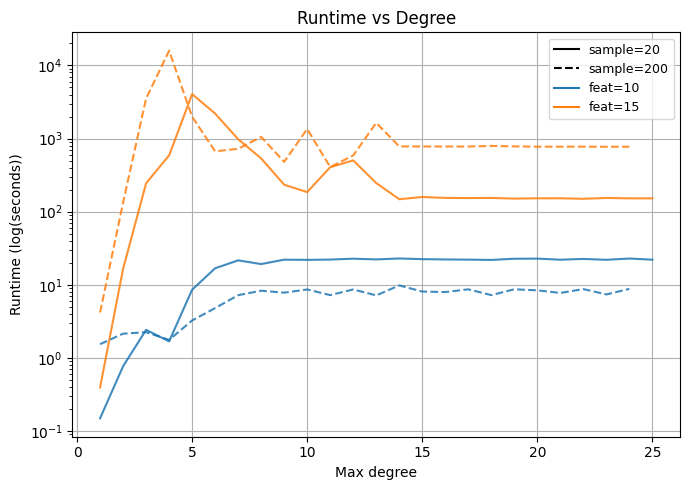

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(7, 5))

# === 映射规则 ===
sample_to_ls = {
    20: '-',
    200: '--'
}

feat_to_color = {
    10: 'tab:blue',
    15: 'tab:orange'
}

# === 画线 ===
for path, sample, feat in files:
    if sample not in sample_to_ls or feat not in feat_to_color:
        continue  # 只画 sample={20,200}, feat={10,15}

    df = pd.read_csv(path)

    plt.plot(
        df['degree'],
        df['runtime_seconds'],
        linestyle=sample_to_ls[sample],
        color=feat_to_color[feat],
        alpha=0.85
    )

# === 自定义 legend（关键点） ===
legend_elements = [
    # sample legend
    Line2D([0], [0], color='black', linestyle='-', label='sample=20'),
    Line2D([0], [0], color='black', linestyle='--', label='sample=200'),

    # feature legend
    Line2D([0], [0], color='tab:blue', linestyle='-', label='feat=10'),
    Line2D([0], [0], color='tab:orange', linestyle='-', label='feat=15'),
]

plt.legend(
    handles=legend_elements,
    fontsize=9,
    ncol=1,
    frameon=True
)
plt.yscale('log')
plt.xlabel("Max degree")
plt.ylabel("Runtime (log(seconds))")
plt.title("Runtime vs Degree")
plt.grid(True)
plt.tight_layout()
plt.savefig('./edge_limits_plot_encoded.png', dpi=300)
plt.show()


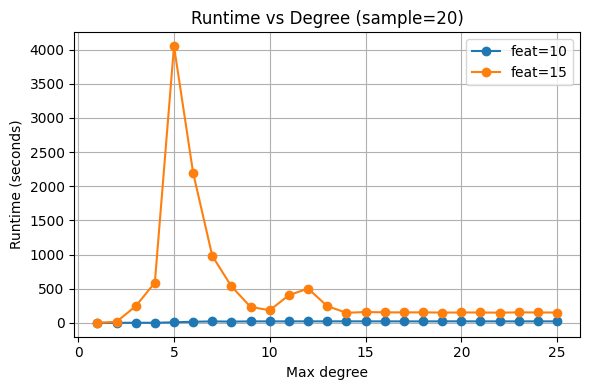

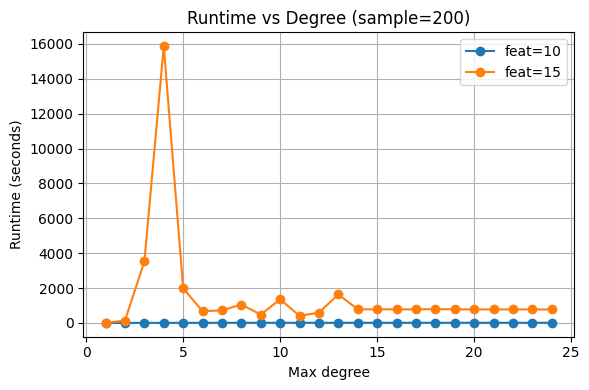

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 固定 sample，按 features 画（最常见）
S_set = [20, 200]
for S in S_set:
    plt.figure(figsize=(6, 4))

    for path, sample, feat in files:
        if sample != S:
            continue

        df = pd.read_csv(path)
        plt.plot(
            df['degree'],
            df['runtime_seconds'],
            marker='o',
            label=f'feat={feat}'
        )

    plt.xlabel("Max degree")
    plt.ylabel("Runtime (seconds)")
    plt.title(f"Runtime vs Degree (sample={S})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'./edge_limits_plot_sample{S}.png', dpi=300)
    plt.show()


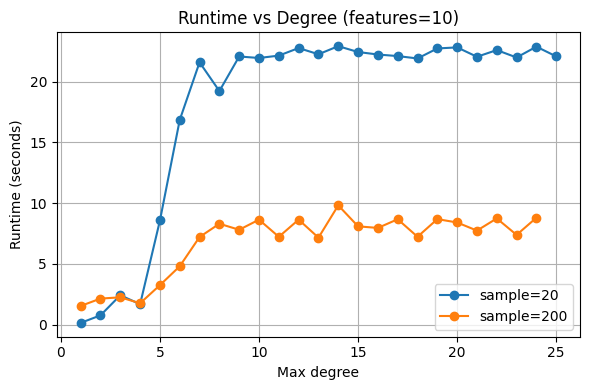

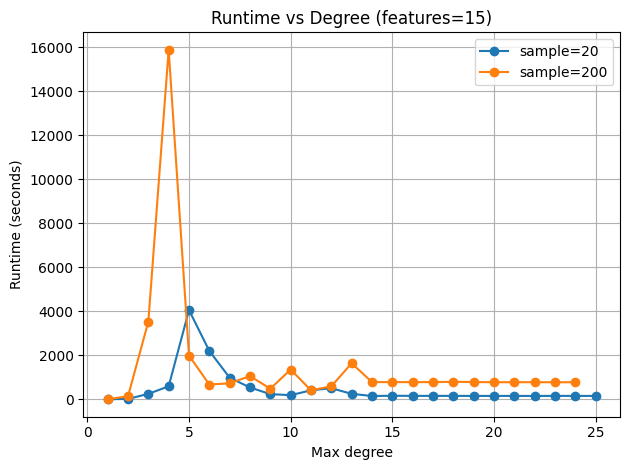

In [ ]:
# 固定 features，按 sample 画
plt.figure(figsize=(6, 4))

F_set = [10, 15]
for F in F_set:
    for path, sample, feat in files:
        if feat != F:   # 🔴 固定 features
            continue

        df = pd.read_csv(path)
        plt.plot(
            df['degree'],
            df['runtime_seconds'],
            marker='o',
            label=f'sample={sample}'
        )

    plt.xlabel("Max degree")
    plt.ylabel("Runtime (seconds)")
    plt.title(f"Runtime vs Degree (features={F})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'./edge_limits_plot_feat{F}.png', dpi=300)
    plt.show()


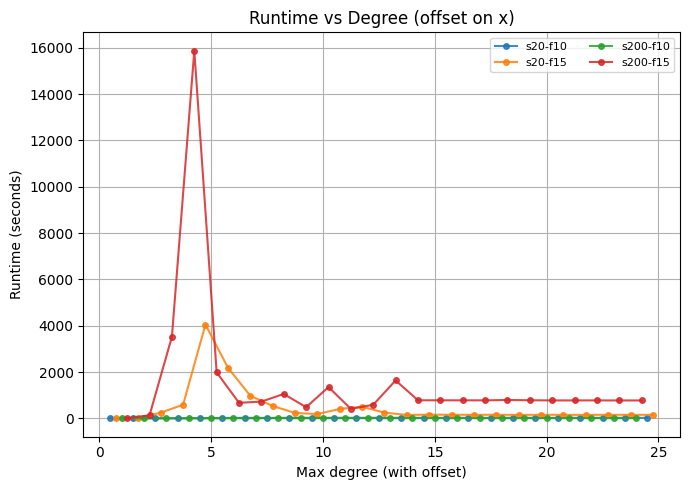

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 5))

offset_step = 0.25   # degree 偏移
i = 0

for path, sample, feat in files:
    df = pd.read_csv(path)

    x = df['degree'].to_numpy()
    y = df['runtime_seconds'].to_numpy()

    # 对 x 做偏移（不破坏 runtime）
    x_offset = x + (i - len(files)/2) * offset_step

    plt.plot(
        x_offset,
        y,
        label=f's{sample}-f{feat}',
        alpha=0.85,
        marker='o',
        markersize=4
    )
    i += 1

plt.xlabel("Max degree (with offset)")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime vs Degree (offset on x)")
plt.legend(fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('./edge_limits_plot_all_offset.png', dpi=300)
plt.show()


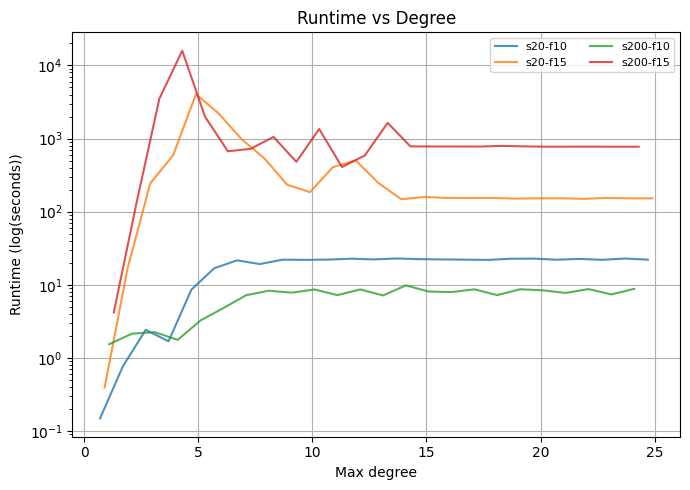

In [ ]:
unique_lines = len(files)
offsets = np.linspace(-0.3, 0.3, unique_lines)

plt.figure(figsize=(7, 5))

for (path, sample, feat), off in zip(files, offsets):
    df = pd.read_csv(path)
    x = df['degree'].to_numpy() + off
    y = df['runtime_seconds'].to_numpy()

    plt.plot(x, y, label=f's{sample}-f{feat}', alpha=0.8)
plt.yscale('log')
plt.xlabel("Max degree")
plt.ylabel("Runtime (log(seconds))")
plt.title("Runtime vs Degree")
plt.legend(fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('./edge_limits_plot_all_grouped_offset.png', dpi=300)
plt.show()


## Plot2

In [ ]:
import pandas as pd

df_ref = pd.read_csv(files[0][0])
num_rows = df_ref.shape[0]

for nr in range(num_rows):
    first_rows = []

    for path, sample, feat in files:
        df = pd.read_csv(path)

        if nr < df.shape[0]:
            row = df.iloc[nr].copy()
            row['sample'] = sample
            row['features'] = feat
            first_rows.append(row)
        else:
            print(f"skip sample={sample}, feat={feat}, row={nr}")

    if first_rows:
        combined_df = pd.DataFrame(first_rows)

        # 列顺序（sample, features 放最前）
        cols = ['sample', 'features'] + \
               [c for c in combined_df.columns if c not in ['sample', 'features']]
        combined_df = combined_df[cols].reset_index(drop=True)

        degree = int(combined_df['degree'].iloc[0])
        combined_df.to_csv(f'./runtime_edges_degree_{degree}.csv', index=False)


skip sample=200, feat=10, row=24
skip sample=200, feat=15, row=24


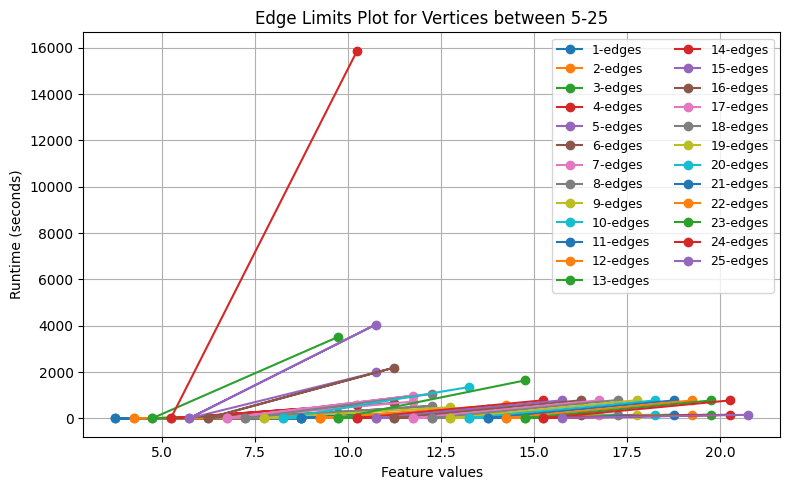

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# 获取所有 runtime_edges_*.csv
csv_files = glob.glob('./runtime_edges_degree_*.csv')
files = []
for path in csv_files:
    base = os.path.basename(path)
    tag = base.replace('runtime_edges_degree_', '').replace('.csv', '')
    files.append((path, tag))

files.sort(key=lambda x: int(x[1]))

plt.figure(figsize=(8,5))

# Horizontal line plot: x and y swapped
for i, (path, tag) in enumerate(files):
    df = pd.read_csv(path)

    # 给每条线的 x 轴加一个微小偏移，避免重叠
    jitter = (i - len(files)/2) * 0.5  # 根据总文件数微调偏移
    x = df['features'] + jitter

    plt.plot(x, df['runtime_seconds'], marker='o', label=f"{tag}-edges")

plt.legend(
    fontsize=9,
    ncol=2,
    frameon=True
)
plt.xlabel("Feature values")
plt.ylabel("Runtime (seconds)")
plt.title("Edge Limits Plot for Vertices between 5-25")
plt.grid(True)
plt.tight_layout()
plt.savefig('./edge_limits_plot_e.png', dpi=300)
plt.show()


 Test 1

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from notears import utils
import omegaconf as OmegaConf
#from castle.common import GraphDAG
#from castle.metrics import MetricsDAG
from sklearn.preprocessing import LabelEncoder

df = df2.iloc[:, :10]
X = df.to_numpy()
col_mean_X = np.nanmean(X, axis=0)        # 每列的均值
inds_X = np.where(np.isnan(X))            # 找到 NaN 的索引
X[inds_X] = np.take(col_mean_X, inds_X[1])  # 用列均值填充

intra_nodes = df.columns.tolist()
inter_nodes = []

W_true = np.zeros((X.shape[1], X.shape[1]))
B_true = np.zeros((X.shape[1], X.shape[1]))
A_true = []
Y = []
cfg = OmegaConf.DictConfig({})
cfg.time_limit = 1800
cfg.constraints_mode = 'weights'
cfg.callback_mode = 'all_cycles'
cfg.lambda1=1
cfg.lambda2=1
cfg.loss_type='l2'
cfg.reg_type='l1'
cfg.a_reg_type='l1'
cfg.robust = False
cfg.weights_bound = 100
cfg.target_mip_gap = 0.001
cfg.tabu_edges = False
cfg.plot_dpi = 100
max_in_degree=5
max_out_degree=5

W_est, A_est, gap, lazy_count, stats = solve_milp(X, cfg, 0, max_in_degree, max_out_degree, Y=Y, B_ref=B_true)
causal_matrix = dag_adj_binary(W_est)
#GraphDAG(causal_matrix, true_dag, save_name='Result_DBN')
#met = MetricsDAG(causal_matrix, true_dag)
#print(met.metrics)
#df = pd.DataFrame([met.metrics])
#df.to_csv(f'Scores_DBN_{file_name}.csv')

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2611849
Academic license 2611849 - for non-commercial use only - registered to he___@cvut.cz


KeyboardInterrupt: 

Test 2

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from notears import utils
import omegaconf as OmegaConf
from sklearn.preprocessing import LabelEncoder

intra_nodes = df.columns.tolist()
inter_nodes = []

A_true = []
Y = []
cfg = OmegaConf.DictConfig({})
cfg.time_limit = 1800
cfg.constraints_mode = 'weights'
cfg.callback_mode = 'all_cycles'
cfg.lambda1=1
cfg.lambda2=1
cfg.loss_type='l2'
cfg.reg_type='l1'
cfg.a_reg_type='l1'
cfg.robust = False
cfg.weights_bound = 100
cfg.target_mip_gap = 0.001
cfg.tabu_edges = False
cfg.plot_dpi = 100
max_in_degree=5
max_out_degree=5

features_list = [10, 20]  # 40, 60, 80
max_degree_start = 5
max_degree_step = 5

# 记录最大可行度
results = []

for features in features_list:
    print(f"\nTesting features = {features}")
    df = df2.iloc[:, :features]
    X = df.to_numpy()
    W_true = np.zeros((X.shape[1], X.shape[1]))
    B_true = np.zeros((X.shape[1], X.shape[1]))
    col_mean_X = np.nanmean(X, axis=0)        # 每列的均值
    inds_X = np.where(np.isnan(X))            # 找到 NaN 的索引
    X[inds_X] = np.take(col_mean_X, inds_X[1])  # 用列均值填充

    d = X.shape[1]

    max_degree = max_degree_start
    max_in_degree_test = 0
    max_out_degree_test = 0

    while True:
        try:
            max_in_degree = max_degree
            max_out_degree = max_degree

            print(f"Trying max_degree={max_degree}")

            # 调用 solve_milp，需要修改函数支持 in/out degree 参数
            W_est, A_est, gap, lazy_count, stats = solve_milp(
                X, cfg, 0, max_in_degree, max_out_degree, Y=Y, B_ref=B_true
            )

            if W_est is None:
                print(f"Not feasible for degree={max_degree}")
                break

            causal_matrix = dag_adj_binary(W_est)
            causal_matrix = np.array(causal_matrix)
            np.save(f"exdbn_edges_{features}_{max_degree}.npy", causal_matrix)

            print(f"Feasible for max_degree={max_degree}")
            max_in_degree_test = max_in_degree
            max_out_degree_test = max_out_degree

            max_degree += max_degree_step  # 增加限制尝试更大值

        except Exception as e:
            print(f"Error at max_degree={max_degree}: {e}")
            break

    results.append({
        "features": features,
        "max_in_degree": max_in_degree_test,
        "max_out_degree": max_out_degree_test
    })

print("\nMaximum feasible in/out degree for each feature subset:")
for r in results:
    print(r)



Testing features = 40
Trying max_degree=5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2611849
Academic license 2611849 - for non-commercial use only - registered to he___@cvut.cz
0.0
Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 2611849 - for non-commercial use only - registered to he___@cvut.cz
Optimize a model with 3980 rows, 3120 columns and 10920 nonzeros
Model fingerprint: 0xd5925528
Model has 31200 quadratic objective terms
Variable types: 1560 continuous, 1560 integer (1560 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [9e-04, 2e+13]
  QObjective range [1e-03, 8e+13]
  Bounds range     

In [ ]:
import numpy as np

def elbow_point(x, y):
    x = np.array(x)
    y = np.array(y)

    p1 = np.array([x[0], y[0]])
    p2 = np.array([x[-1], y[-1]])

    distances = []
    for i in range(len(x)):
        p = np.array([x[i], y[i]])
        distance = np.abs(np.cross(p2 - p1, p1 - p)) / np.linalg.norm(p2 - p1)
        distances.append(distance)

    idx = np.argmax(distances)
    return x[idx]

x = [1, 2, 3]
y = [10, 6, 5]


In [ ]:
# Find elbow

In [ ]:
import numpy as np

def find_elbow(x, y):
    x = np.array(x)
    y = np.array(y)
    dy = np.diff(y)
    ddy = np.diff(dy)
    elbow_index = np.argmax(np.abs(ddy)) + 2
    return x[elbow_index-1]

elbow = find_elbow(degree, loss)
print("Elbow =", elbow)
